## Final Project Yao Tong 1007410295

#### Open the data file

In [1]:
import re 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import html
import string
import nltk 
import itertools
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# When using Google Codlab. Import os to open the csv file from the google drive.
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/metadata.csv")
all = df.copy()

In [4]:
df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497901,czi422ej,NaN,Medline; PMC,Management des Anaphylaxie-Risikos bei Covid-1...,10.1007/s00060-021-7480-3,PMC7890774,3.36194e+07,no-cc,NaN,2021-02-26,"Worm, Margitta; Ring, Johannes; Klimek, Ludger...",HNO Nachr,NaN,NaN,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pubmed/33619418/;...,231952120.0
497902,9tkuvp7u,196dcd27b37230789787ec9e161731923f7a01e2,Elsevier; Medline; PMC,"EJVES on the Rise Again, and the Annual Meetin...",10.1016/j.ejvs.2020.08.009,PMC7428730,3.28077e+07,no-cc,NaN,2020-08-15,"Dick, Florian; Björck, Martin; Haulon, Stéphan",Eur J Vasc Endovasc Surg,NaN,NaN,NaN,document_parses/pdf_json/196dcd27b37230789787e...,document_parses/pmc_json/PMC7428730.xml.json,https://api.elsevier.com/content/article/pii/S...,221117467.0
497903,9djaqk36,2aec20c10785448b3d01e9de635004cb61d89b46,Medline; PMC,Probable Longer Incubation Period for Elderly ...,10.2147/rmhp.s257907,PMC7429221,3.28485e+07,cc-by-nc,BACKGROUND: Factors associated with the incuba...,2020-08-11,"Dai, Jingyi; Yang, Lin; Zhao, Jun",Risk Manag Healthc Policy,NaN,NaN,NaN,document_parses/pdf_json/2aec20c10785448b3d01e...,document_parses/pmc_json/PMC7429221.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32848488/;...,221295078.0
497904,84abso5p,3cfdd9bdbde8e578900363f30e853a46c8d3aeec,Medline; PMC,A comprehensive survey of AI-enabled phishing ...,10.1007/s11235-020-00733-2,PMC7581503,3.31103e+07,no-cc,"In recent times, a phishing attack has become ...",2020-10-23,"Basit, Abdul; Zafar, Maham; Liu, Xuan; Javed, ...",Telecommun Syst,NaN,NaN,NaN,document_parses/pdf_json/3cfdd9bdbde8e57890036...,document_parses/pmc_json/PMC7581503.xml.json,https://doi.org/10.1007/s11235-020-00733-2; ht...,

In [5]:
# Only keep the data column with title, abstract, authors, and publish_time
df = df[['title','abstract','authors','publish_time']]
df.head()

,title,abstract,authors,publish_time
0,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04
1,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",2000-08-15
2,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,"Crouch, Erika C",2000-08-25
3,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22
4,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",2001-05-11


In [6]:
print(df.shape)

(497906, 4)


In [7]:
#drop duplicates
df = df.drop_duplicates(subset='abstract', keep="first")
#drop NANs 
df=df.dropna()
print(df.shape)

(321013, 4)


### Data Cleaning

In [8]:
# Define the function which combined basic text cleaning process
def data_cleaning(text):    
    
    # Lower the text 
    text = text.lower()
    # remove all stopwords in text column
    stop = stopwords.words('english')
    t = [t for t in text.split() if t not in stop]
    text = ' '.join(t) 

    return text
    

In [9]:
# lower and remove stop words in title and abstract column
df['title'] = df['title'].apply(lambda x:data_cleaning(x))
df['abstract'] = df['abstract'].apply(lambda x:data_cleaning(x))
df

,title,abstract,authors,publish_time
0,clinical features culture-proven mycoplasma pn...,objective: retrospective chart review describe...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04
1,nitric oxide: pro-inflammatory mediator lung d...,inflammatory diseases respiratory tract common...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",2000-08-15
2,surfactant protein-d pulmonary host defense,surfactant protein-d (sp-d) participates innat...,"Crouch, Erika C",2000-08-25
3,role endothelin-1 lung disease,endothelin-1 (et-1) 21 amino acid peptide dive...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22
4,gene expression epithelial cells response pneu...,respiratory syncytial virus (rsv) pneumonia vi...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",2001-05-11
...,...,...,...,...
497899,subclinical ocular inflammation persons recove...,coronavirus disease 2019 (covid-19) characteri...,"Bakhoum, M. F.; Ritter, M.; Garg, A.; Chan, A....",2020-09-23
497900,covid-19 strike twice?,study suggests primary sars-cov-2 exposure may...,"York, Ashley",2020-07-20
497903,probable longer incubation period elderly covi...,background: factors associated incubation peri...,"Dai, Jingyi; Yang, Lin; Zhao, Jun",2020-08-11
497904,comprehensive survey ai-enabled phishing attac...,"recent times, phishing attack become one promi...","Basit, Abdul; Zafar, Maham; Liu, Xuan; Javed, ...",2020-10-23


#### Identify the coronavirus type for each research paper

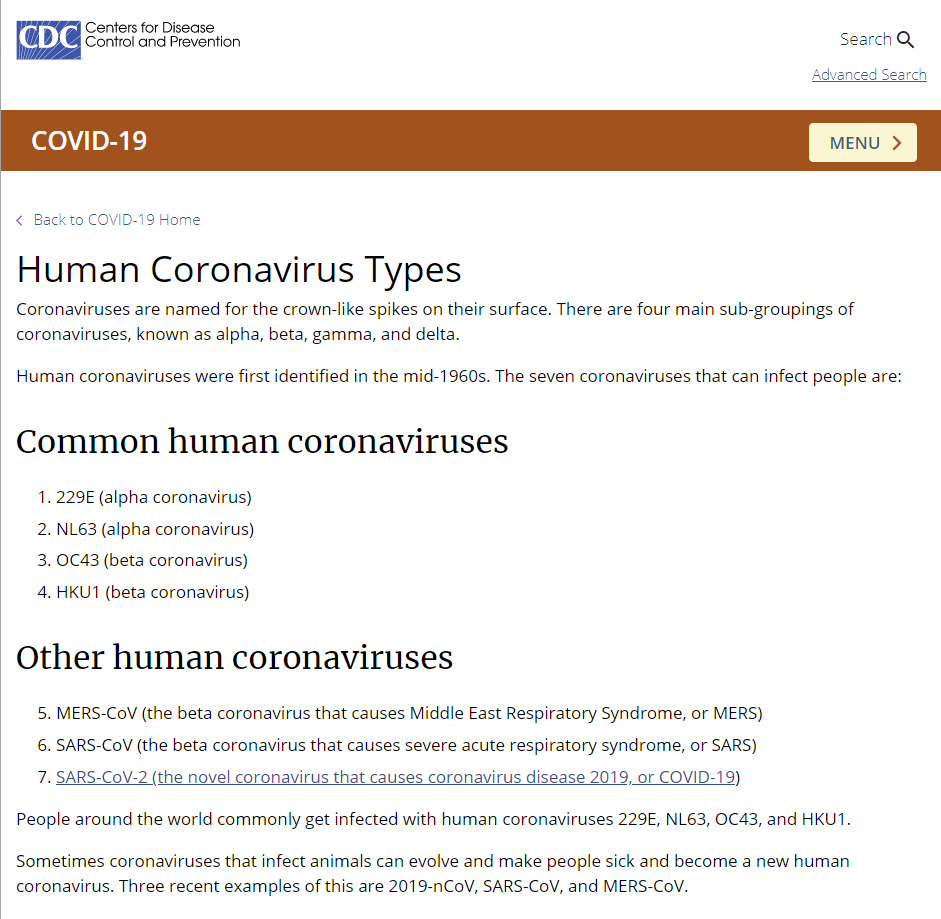

In [10]:
# open the web image as reference to identify coronavirus:
from IPython.display import Image
Image('/content/drive/MyDrive/Colab Notebooks/data/identify coronaviruses.png')

Based on the results of CDC, the coronavirus can be identified with 7 types: 229e, nl63, oc43, hku1, mers-cov, sars-cov, and sars-cov-2.

In [11]:
# the 'title' feature and 'abstract' all may talk about the key words. Therefore, combine them together to be the new column called 'text'
df['text'] = df['title'] + ' ' + df['abstract']
df.head()

,title,abstract,authors,publish_time,text
0,clinical features culture-proven mycoplasma pn...,objective: retrospective chart review describe...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04,clinical features culture-proven mycoplasma pn...
1,nitric oxide: pro-inflammatory mediator lung d...,inflammatory diseases respiratory tract common...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",2000-08-15,nitric oxide: pro-inflammatory mediator lung d...
2,surfactant protein-d pulmonary host defense,surfactant protein-d (sp-d) participates innat...,"Crouch, Erika C",2000-08-25,surfactant protein-d pulmonary host defense su...
3,role endothelin-1 lung disease,endothelin-1 (et-1) 21 amino acid peptide dive...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22,role endothelin-1 lung disease endothelin-1 (e...
4,gene expression epithelial cells response pneu...,respiratory syncytial virus (rsv) pneumonia vi...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",2001-05-11,gene expression epithelial cells response pneu...


identify the coronavirus type by column 'text'

In [12]:
def classify_coronavirus(text):
    # select the following key words to define types of coronavirus
    c229e_list = ['229e','hcov-229e']
    nl63_list = ['nl63','hcov-nl63']
    oc43_list = ['oc43','hcov-oc43']
    hku1_list = ['hku1','hcov-hku1']

    mers_list = ['mers-cov','mers']
    sars_list = ['sars-cov','sars']
    covid19_list = ['sars-cov-2','covid-19']

    count_dict = {'229e':0,'nl63':0,'oc43':0,'hku1':0,'mers':0,'sars':0,'covid19':0}

    # for if loop to split types based on the key words list
    for t in text.split():
        if t in c229e_list:
            count_dict['229e']+=1
        if t in nl63_list:
            count_dict['nl63']+=1
        if t in oc43_list:
            count_dict['oc43']+=1
        if t in hku1_list:
            count_dict['hku1']+=1
        if t in mers_list:
            count_dict['mers']+=1
        if t in sars_list:
            count_dict['sars']+=1
        if t in covid19_list:
            count_dict['covid19']+=1        

        
    # Choose the coronavirus type with the highest number of the coronavirus type keywords
    max_list=[]
    max_value = max(count_dict.values())
    # the other types of coronavirus papers or no specifit type papers call other
    if max_value == 0:
      return 'other'
    else:
      for m,n in count_dict.items():
          if n == max_value:
              max_list.append(m)

      if len(max_list) >1:
          return 'multi'  
      else:
          return max_list[0]

In [13]:
# Identify the coronavirus type by text column
df['coronavirus type'] = df['text'].apply(lambda x:classify_coronavirus(x))
df

,title,abstract,authors,publish_time,text,coronavirus type
0,clinical features culture-proven mycoplasma pn...,objective: retrospective chart review describe...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04,clinical features culture-proven mycoplasma pn...,other
1,nitric oxide: pro-inflammatory mediator lung d...,inflammatory diseases respiratory tract common...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",2000-08-15,nitric oxide: pro-inflammatory mediator lung d...,other
2,surfactant protein-d pulmonary host defense,surfactant protein-d (sp-d) participates innat...,"Crouch, Erika C",2000-08-25,surfactant protein-d pulmonary host defense su...,other
3,role endothelin-1 lung disease,endothelin-1 (et-1) 21 amino acid peptide dive...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22,role endothelin-1 lung disease endothelin-1 (e...,other
4,gene expression epithelial cells response pneu...,respiratory syncytial virus (rsv) pneumonia vi...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",2001-05-11,gene expression epithelial cells response pneu...,other
...,...,...,...,...,...,...
497899,subclinical ocular inflammation persons recove...,coronavirus disease 2019 (covid-19) characteri...,"Bakhoum, M. F.; Ritter, M.; Garg, A.; Chan, A....",2020-09-23,subclinical ocular inflammation persons recove...,covid19
497900,covid-19 strike twice?,study suggests primary sars-cov-2 exposure may...,"York, Ashley",2020-07-20,covid-19 strike twice? study suggests primary ...,covid19
497903,probable longer incubation period elderly covi...,background: factors associated incubation peri...,"Dai, Jingyi; Yang, Lin; Zhao, Jun",2020-08-11,probable longer incubation period elderly covi...,covid19
497904,comprehensive survey ai-enabled phishing attac...,"recent times, phishing attack become one promi...","Basit, Abdul; Zafar, Maham; Liu, Xuan; Javed, ...",2020-10-23,comprehensive survey ai-enabled phishing attac...,other


### Data Visualization and Exploratory Data Analysis

#### Visualization of paper coronavirus types 

In [14]:
# report the count value of different coronavirus type papers
type_df= pd.DataFrame(df['coronavirus type'].value_counts())
type_df

,coronavirus type
covid19,157645
other,154653
sars,5125
mers,1637
multi,1153
229e,292
oc43,274
nl63,165
hku1,69


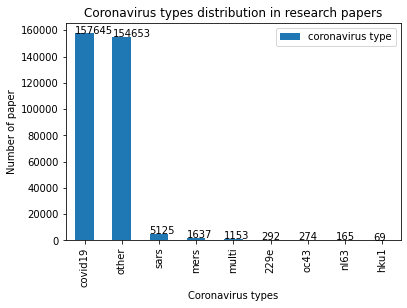

In [15]:
# visualizayion the frequency distribution 

type_plot = type_df.plot.bar()
for p in type_plot.patches:  
    type_plot.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1))

plt.xlabel('Coronavirus types')  
plt.ylabel('Number of paper')
plt.title('Coronavirus types distribution in research papers')

plt.show()


##### Results

Based on the paper distribution with different coronuvirus types: most research paper focus on covid-19 and not specific coronuvirus type. Then is sars. Therefore only do the coronuvirus classification in this project is meaningless.


Then, I am very intersted about how the coronuvirus paper increase during this  COVID-19 pandemic.

#### Paper publish time analyzation

In [16]:
all = all[['title','publish_time']]
all=all.dropna()
print(all.shape)

(497455, 2)


In [17]:
# For the pubilish_time column only keep the year value
all.loc[:,'publish_time'] = all['publish_time'].apply(lambda x: x[:4])
time_all= pd.DataFrame(all['publish_time'].value_counts())
time_all = time_all[:20]

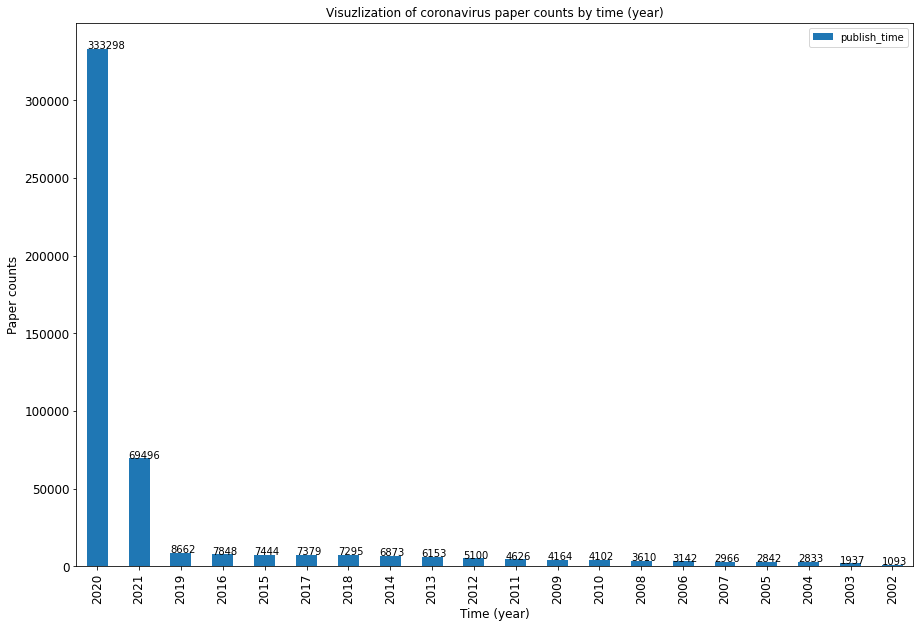

In [18]:
# plot the pubilish time sorted distribution of all paper data
ax = time_all.plot(kind='bar', title = "Visuzlization of coronavirus paper counts by time (year)", figsize=(15, 10), legend=True, fontsize=12)
for p in ax.patches:  
    ax.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1))
ax.set_xlabel("Time (year)", fontsize=12)
ax.set_ylabel("Paper counts", fontsize=12)
plt.show()

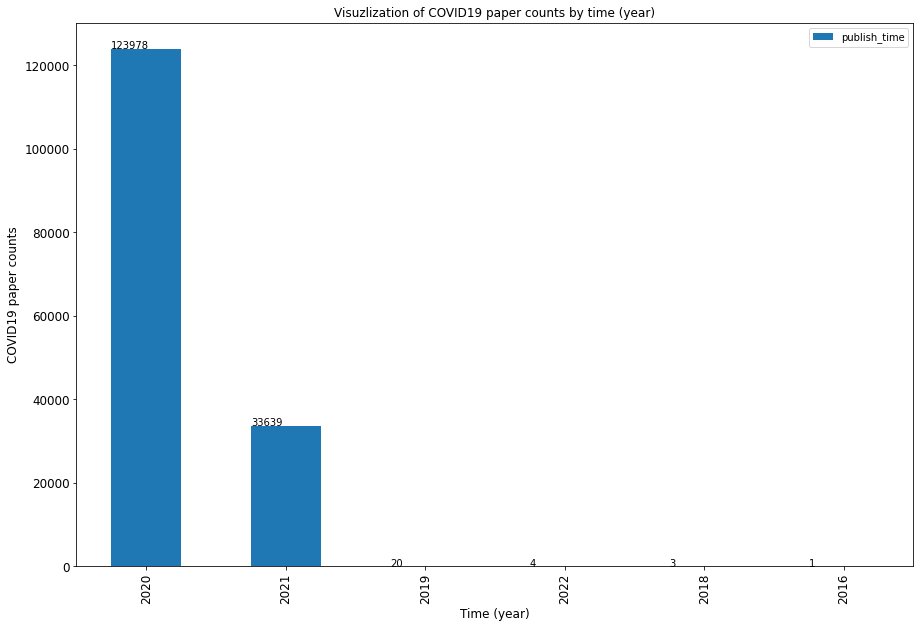

In [19]:
# plot the pubilish time sorted distribution of COVID19 paper data
covid19_paper= df[df["coronavirus type"] == 'covid19']
covid19_paper.loc[:,'publish_time'] = covid19_paper['publish_time'].apply(lambda x: x[:4])
time_df= pd.DataFrame(covid19_paper['publish_time'].value_counts())
ax = time_df.plot(kind='bar', title = "Visuzlization of COVID19 paper counts by time (year)", figsize=(15, 10), legend=True, fontsize=12)
for p in ax.patches:  
    ax.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1))
ax.set_xlabel("Time (year)", fontsize=12)
ax.set_ylabel("COVID19 paper counts", fontsize=12)
plt.show()

##### Results

Based on the results of covid-19 paper counts over time. Based on the covid19 pandemic, number of 2020 pubilshed papers over 330,000, and the 2020 COVID19 papers number get 123978. Right now, there are 33639 COVID19 papers pubilished after 2021.   

#### COVID19 paper authors analyzation

In [20]:
covid19_df_copy = covid19_paper.copy()

In [21]:
# build a function to splite author name in authors column
def autors_cleaning(text):
    text = text.lower()
    author_list = []
    split = text.split(';')
    author_list.append(split)
    flat_list = [author for sublist in author_list for author in sublist]

    return flat_list

In [22]:
covid19_df_copy.loc[:,'authors'] = covid19_df_copy['authors'].apply(lambda x:autors_cleaning(x))

In [23]:
covid19_df_copy['authors']

8141      [weckbecker, klaus,  draenert, rika,  höring, ...
10752     [vaishya, raju,  javaid, mohd,  khan, ibrahim ...
10889     [haines, seline,  caccamo, amy,  chan, fonda, ...
10971                                       [reinhardt, d.]
11617     [shekar, kiran,  badulak, jenelle,  peek, gile...
                                ...                        
497896                [deolmi, michela,  pisani, francesco]
497899    [bakhoum, m. f.,  ritter, m.,  garg, a.,  chan...
497900                                       [york, ashley]
497903                [dai, jingyi,  yang, lin,  zhao, jun]
497905    [bradshaw, a.,  dunleavy, l.,  walshe, c.,  pr...
Name: authors, Length: 157645, dtype: object

In [24]:
# repor the authors count list
author_list = list(itertools.chain.from_iterable(covid19_df_copy['authors']))
author_fre = nltk.FreqDist(author_list)

In [56]:
# report the dataframe of sorted authors count calue
author_selected = dict((k, v) for k, v in author_fre.items() if int(v) >= 100)
author_selected = dict(sorted(author_selected.items(), key=lambda item: item[1],reverse=True ))
author_array = pd.DataFrame({'author': list(author_selected.keys()),'Frequency': list(author_selected.values())})   
author_array[3:]

,author,Frequency
3,"wang, y.",168
4,"wang, wei",165
5,"zhang, y.",164
6,"zhang, wei",152
7,"li, y.",150
8,"liu, y.",133
9,"wang, jing",127
10,"liu, lei",126
11,"li, j.",126
12,"wang, j.",124


##### Results

Exept the wrong authors name such as o039 and d039, highest paper count autor is wang, y. with 168 papers.

#### Identify and analyze the symptoms of COVID-19 and other coronaviruses


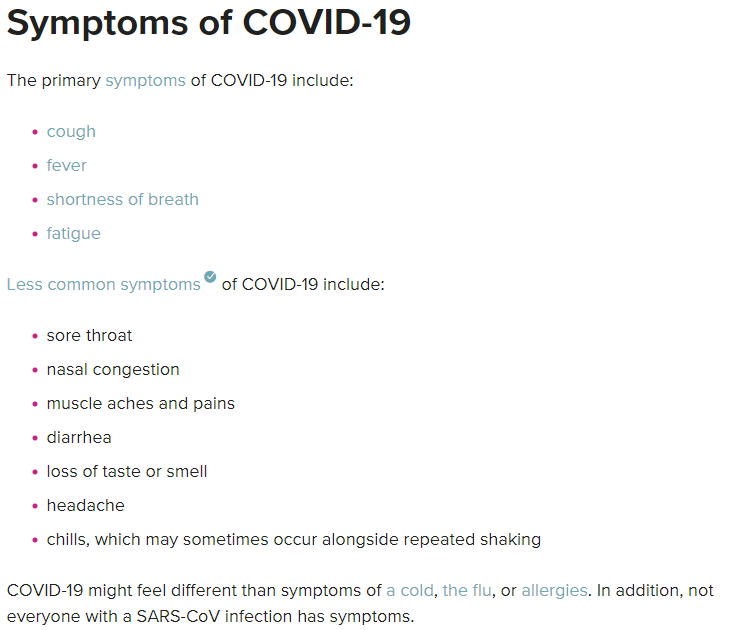

In [26]:
# open the file form CDC which shows the Symptoms of Coronavirus (COVID-19)

Image('/content/drive/MyDrive/Colab Notebooks/data/symptoms.png')

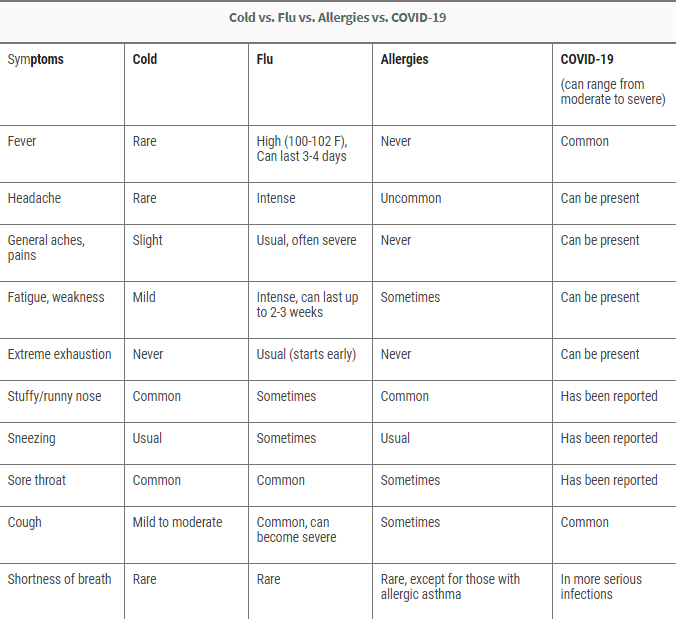

In [27]:
Image('/content/drive/MyDrive/Colab Notebooks/data/symptoms2.png')

In [28]:
# Based on the symptoms information from CDC I select the symptoms list for future analyzation
symptoms = ['cough','fever','fatigue','sore throat','headache','diarrhea','chills','nasal congestion','pneumonia','bronchitis','cold','flu','allergies','sneezing','runny nose','stuffy','weakness','pains','aches']

##### Symptoms analyzation for COVID19 papers

In [29]:
# build function to report the counts value of all symptom words
def symptoms_coronavirus(text):
    symptoms_dict = {'cough':0,'fever':0,'fatigue':0,'sore throat':0,'headache':0,'diarrhea':0,'chills':0,'nasal congestion':0,
              'pneumonia':0,'bronchitis':0,'cold':0,'flu':0,'allergies':0,'sneezing':0,'runny nose':0,'stuffy':0,'weakness':0,'pains':0,'aches':0}
    for m,n in symptoms_dict.items():
        for y in text:
            if m in y:
                symptoms_dict[m] += 1
    symptoms_df = pd.DataFrame.from_dict(symptoms_dict, orient='index',columns=['counts'])
    return symptoms_df
# fit COVID19 paper data to report the counts value of all symptom words
symptoms_covid19_df = symptoms_coronavirus(covid19_paper.text)
symptoms_covid19_df = symptoms_covid19_df.sort_values(by=['counts'], ascending=False)
symptoms_covid19_df

,counts
flu,16100
pneumonia,11183
fever,7323
aches,6590
cough,5615
fatigue,2094
headache,1480
diarrhea,1287
cold,901
weakness,893


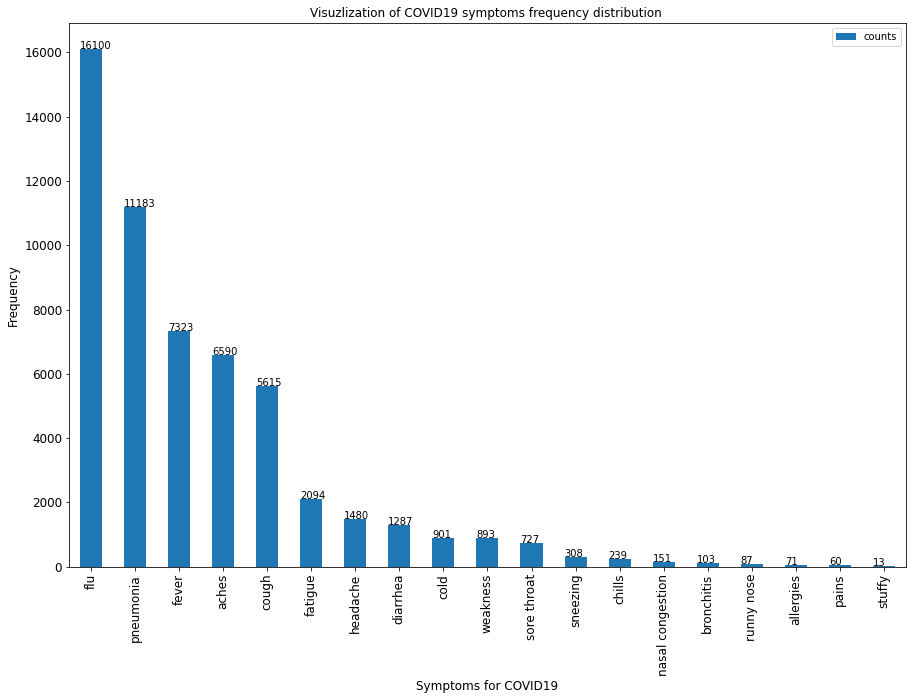

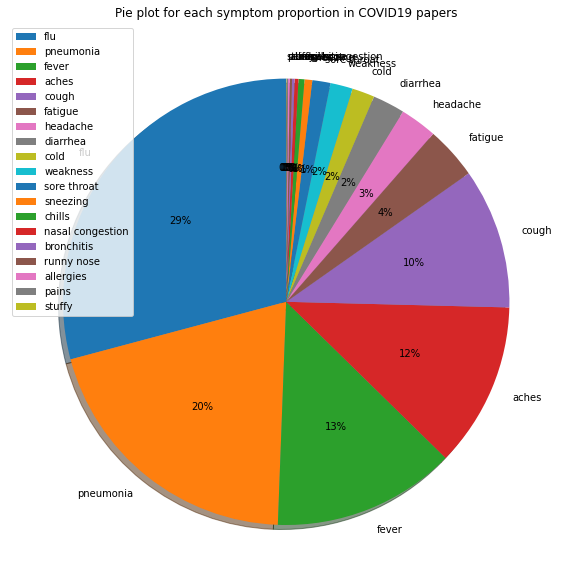

In [30]:
# plot the frequency distribution of symptom words in COVID19 papers
ax = symptoms_covid19_df.plot(kind='bar', title ="Visuzlization of COVID19 symptoms frequency distribution", figsize=(15, 10), legend=True, fontsize=12)
for p in ax.patches:  
    ax.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1))
ax.set_xlabel("Symptoms for COVID19", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.show()
# plot the pie figure of symptom words frequency distribution
list_of_covid19 = symptoms_covid19_df['counts'].to_list()
plt.figure(figsize=(10,15))
plt.pie(list_of_covid19, labels = symptoms_covid19_df.index, startangle=90, shadow = True, autopct = '%1.0f%%')
plt.title('Pie plot for each symptom proportion in COVID19 papers')  

plt.legend()
  
plt.show()

##### Symptoms analyzation for SARS papers

In [31]:
# fit sars paper data to report the counts value of all symptom words
sars_paper= df[df["coronavirus type"] == 'sars']
symptoms_sars_df = symptoms_coronavirus(sars_paper.text)
symptoms_sars_df = symptoms_sars_df.sort_values(by=['counts'], ascending=False)
symptoms_sars_df

,counts
flu,942
pneumonia,385
fever,314
aches,189
cough,159
diarrhea,59
cold,46
headache,42
chills,34
bronchitis,34


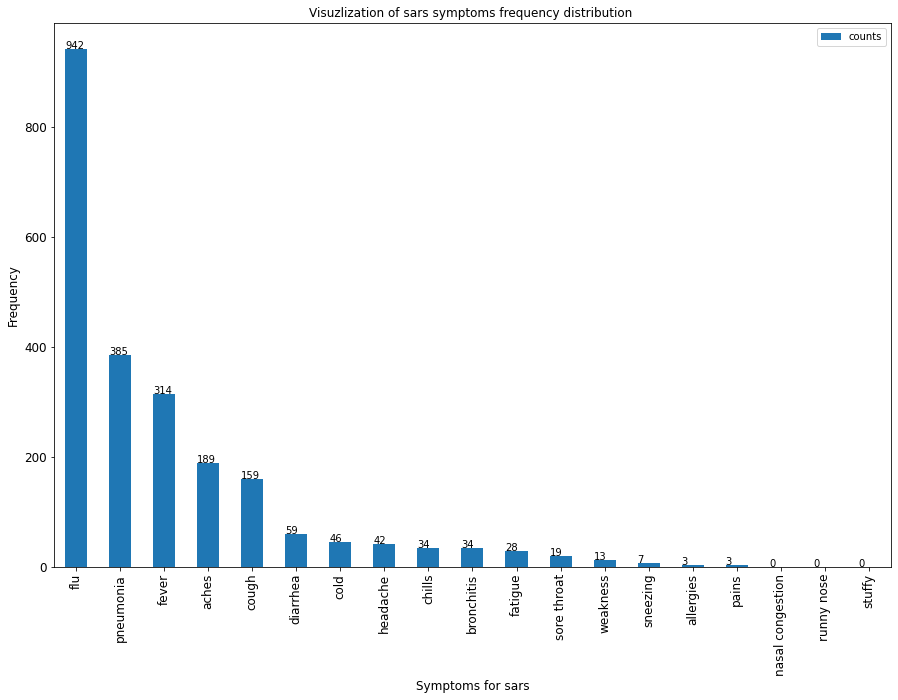

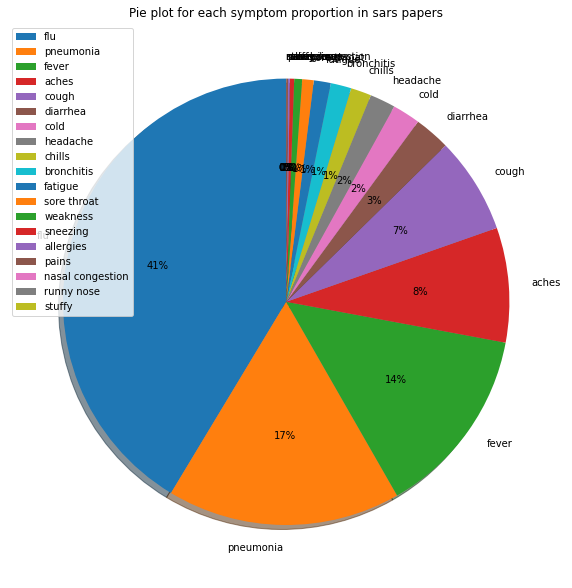

In [57]:
# plot the frequency distribution of symptom words in sars papers
ax = symptoms_sars_df.plot(kind='bar', title ="Visuzlization of sars symptoms frequency distribution ", figsize=(15, 10), legend=True, fontsize=12)
for p in ax.patches:  
    ax.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1))
ax.set_xlabel("Symptoms for sars", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.show()

# plot the pie figure of symptom words frequency distribution
list_of_sars = symptoms_sars_df['counts'].to_list()
plt.figure(figsize=(10,15))
plt.pie(list_of_sars, labels = symptoms_sars_df.index, startangle=90, shadow = True, autopct = '%1.0f%%')
plt.title('Pie plot for each symptom proportion in sars papers')  

plt.legend()
  
plt.show()

##### Symptoms analyzation for ALL papers

In [33]:
# fit all paper data to report the counts value of all symptom words
symptoms_all_df = symptoms_coronavirus(df.text)
symptoms_all_df = symptoms_all_df.sort_values(by=['counts'], ascending=False)
symptoms_all_df


,counts
flu,44891
pneumonia,17647
aches,14816
fever,11646
cough,7581
diarrhea,4207
fatigue,2961
cold,2298
headache,2087
bronchitis,1737


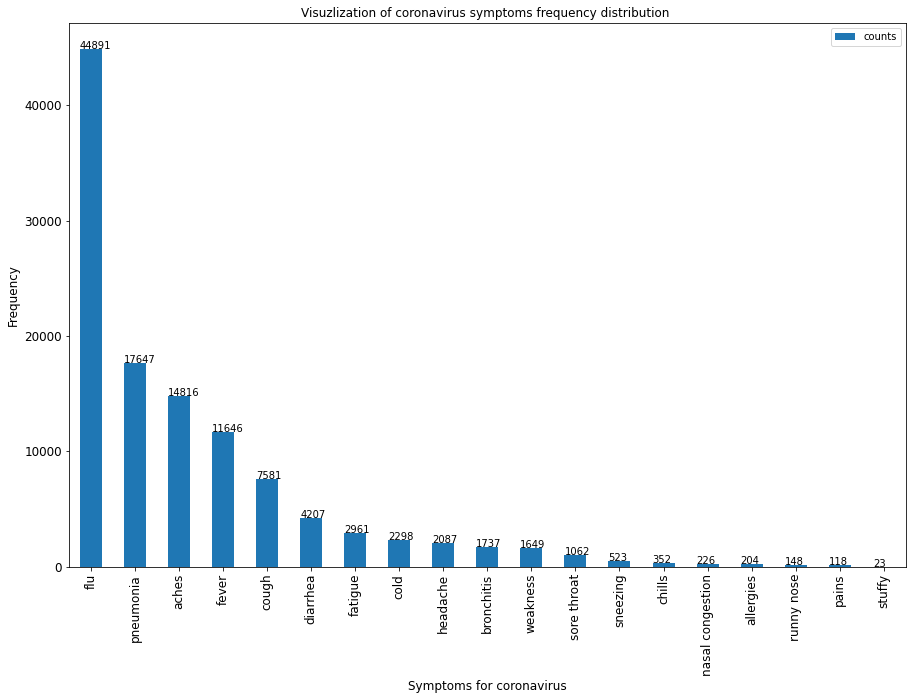

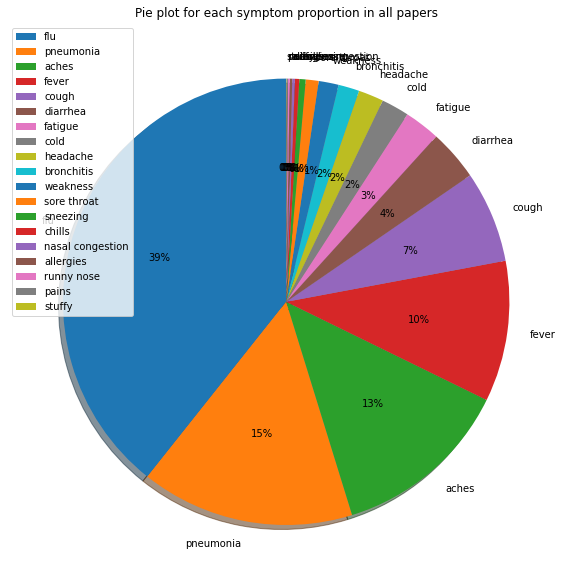

In [34]:
# plot the frequency distribution of symptom words in all papers
ax = symptoms_all_df.plot(kind='bar', title ="Visuzlization of coronavirus symptoms frequency distribution ", figsize=(15, 10), legend=True, fontsize=12)
for p in ax.patches:  
    ax.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1))
ax.set_xlabel("Symptoms for coronavirus", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.show()

# plot the pie figure of symptom words frequency distribution
list_of_all = symptoms_all_df['counts'].to_list()
plt.figure(figsize=(10,15))
plt.pie(list_of_all, labels = symptoms_all_df.index, startangle=90, shadow = True, autopct = '%1.0f%%')
plt.title('Pie plot for each symptom proportion in all papers')  

plt.legend()
  
plt.show()

##### Results

Based on the symptoms count value and frequency ditribution of COVID19 paper, sars paper, and all paper. The results showed the most frequency symptom for both data is flu, lower one is pneumonia.

The symtpoms distribution of COVID19 is very similer with sars. 
But, the symptoms percentage in fatigue	and headache of COVID19 paper are higher than sars paper.

#### Risk factors of COVID19 and other coronavirus

##### Risck factors analyzation for COVID19 papers

In [35]:
# selected the list of risk factors got from web
risk_factors = ['male', 'female', 'age', 'asthma', 'copd',
                'lung cancer','cystic fibrosis','pulmonary fibrosis',
                'heart disease','cardiomyopathy','heart failure','hypertension',
                'diabetes','obesity','cancer','hiv','aids','smoking', 'alcohol']

In [36]:
# build function to report the counts value of all risk factors
def risk_coronavirus(text):
    risk_dict = {'male':0, 'female':0, 'age':0, 'asthma':0, 'copd':0,
                'lung cancer':0,'cystic fibrosis':0,'pulmonary fibrosis':0,
                'heart disease':0,'cardiomyopathy':0,'heart failure':0,'hypertension':0,
                'diabetes':0,'obesity':0,'cancer':0,'hiv':0,'aids':0,'smoking':0, 'alcohol':0}
    for m,n in risk_dict.items():
        for y in text:
            if m in y:
                risk_dict[m] += 1
    risk_df = pd.DataFrame.from_dict(risk_dict, orient='index',columns=['counts'])
    return risk_df
# fit COVID19 paper data to report counts value of all risk factors
risk_covid19_df = risk_coronavirus(covid19_paper.text)
risk_covid19_df = risk_covid19_df.sort_values(by=['counts'], ascending=False)
risk_covid19_df

,counts
age,83218
male,13235
female,7218
diabetes,5491
cancer,5156
hypertension,4267
obesity,2391
hiv,1957
smoking,1351
alcohol,1274


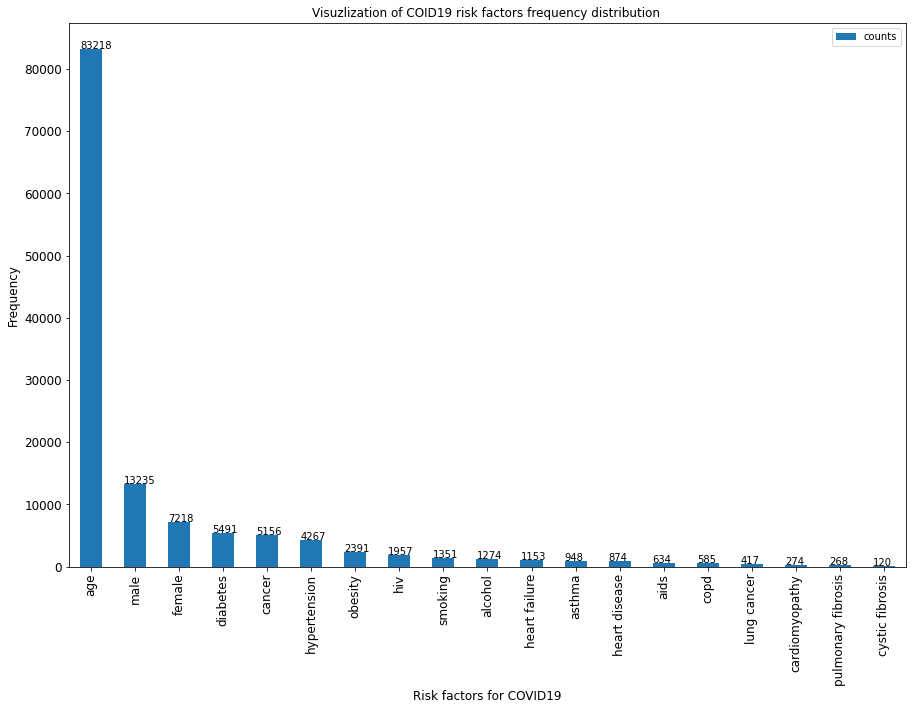

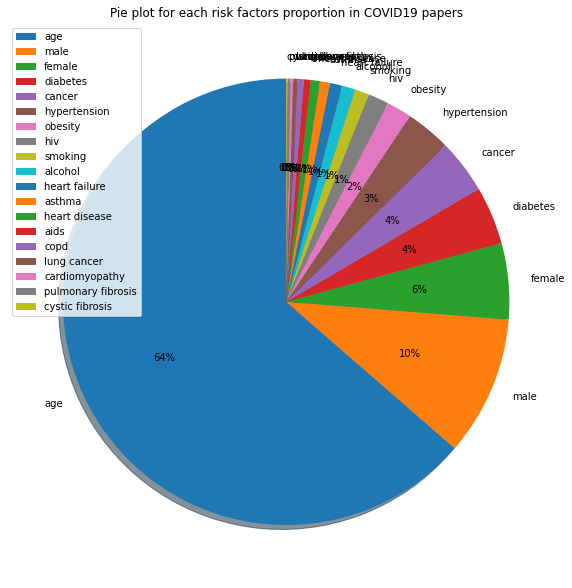

In [58]:
# plot the frequency distribution of risk factors words in covid19 papers
ax = risk_covid19_df.plot(kind='bar', title ="Visuzlization of COID19 risk factors frequency distribution ", figsize=(15, 10), legend=True, fontsize=12)
for p in ax.patches:  
    ax.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1))
ax.set_xlabel("Risk factors for COVID19", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.show()

# plot the pie figure of risk factors frequency distribution
list_of_all = risk_covid19_df['counts'].to_list()
plt.figure(figsize=(10,15))
plt.pie(list_of_all, labels = risk_covid19_df.index, startangle=90, shadow = True, autopct = '%1.0f%%')
plt.title('Pie plot for each risk factors proportion in COVID19 papers')  

plt.legend()
  
plt.show()

##### Results

For the risk factors analyzation in COVID19 paper data. The highest risk factor is age which get far higher value (64%) than other factors. The second high factor is gender. Then, the following factors are diabetes, cancer, and hypertension.

#### Discussion

During this part. I analyzed five direction of this coronavirus research paper data. 

For coronavirus type classification and analyzation: about half of all papers are COVID19, and half of all papers are other types or general coronavirus. Based on these results. I will focus on the COVID19 paper in the future analyzationg and modeling part.

For paper publish time analyzation, most of paper pubulished during 2020. which influenced by COVID19 pandemic.

For the authors analyzation, most authors are Asian.

For the coronavirus symptoms analyzation, the symtpoms distribution of COVID19 is very similer with sars paper and all papers. However, we still can find the difference. Such as, the symptoms percentage in fatigue and headache of COVID19 paper are higher than sars paper.

For the coronavirus risk factors analyzation, the most important risk factor is age and second is gender, third include some diseases. Based on these results, hospital and goverment should pay more attention to people with higher risk factors. Such as child, oder aults, and people with other diseases. 


### Model selection and fitting to data

#### Association of coronavirus symptoms

Build model to answer the questions: Determine the association of coronavirus symptoms

##### Analyze assosiation of symptoms using euclidean Distance

In [38]:
# count the symptom words from text column and report the words count dataframe
column_symptoms1 = covid19_paper['text'].str.contains(symptoms[0]).astype('uint')
symptoms_df = pd.DataFrame(data=[column_symptoms1]).T

for i in range(len(symptoms)-1):
    colum_symptoms = covid19_paper['text'].str.contains(symptoms[i+1]).astype('uint')
    colum_symptoms_df = pd.DataFrame(data=[colum_symptoms]).T
    symptoms_df = pd.concat([symptoms_df,colum_symptoms_df], axis=1)
symptoms_df.columns = symptoms
symptoms_df.head()

,cough,fever,fatigue,sore throat,headache,diarrhea,chills,nasal congestion,pneumonia,bronchitis,cold,flu,allergies,sneezing,runny nose,stuffy,weakness,pains,aches
8141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10752,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10971,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11617,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
# report the count value of all symptoms
count = symptoms_df.sum()
count

cough                5615
fever                7323
fatigue              2094
sore throat           727
headache             1480
diarrhea             1287
chills                239
nasal congestion      151
pneumonia           11183
bronchitis            103
cold                  901
flu                 16100
allergies              71
sneezing              308
runny nose             87
stuffy                 13
weakness              893
pains                  60
aches                6590
dtype: int64

Same as the symptoms analyzation for COVID19 papers before

In [62]:
# Based on the words count dataframe report the assosication dataframe with all symptoms using euclidean distance
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
symptoms_T = symptoms_df.T
distance_array = squareform(pdist(symptoms_T))
distance_df = pd.DataFrame(distance_array, columns=symptoms_T.index, index=symptoms_T.index)
distance_df

,cough,fever,fatigue,sore throat,headache,diarrhea,chills,nasal congestion,pneumonia,bronchitis,cold,flu,allergies,sneezing,runny nose,stuffy,weakness,pains,aches
cough,0.000000,66.753277,72.807967,71.749564,75.531450,74.966659,74.525164,74.471471,118.760263,75.445344,79.661785,142.853071,75.325958,73.136858,74.672619,74.899933,79.018985,75.026662,108.613995
fever,66.753277,0.000000,83.180527,82.873397,85.317056,84.071398,84.498521,85.276022,122.735488,86.046499,89.810912,147.624524,85.860352,86.608314,85.416626,85.521927,88.859440,85.632938,115.762688
fatigue,72.807967,83.180527,0.000000,48.010416,52.611786,53.169540,47.085029,46.249324,111.673632,46.786750,54.230987,133.199099,46.465041,48.559242,46.054316,45.793013,53.338541,46.260134,92.021737
sore throat,71.749564,82.873397,48.010416,0.000000,41.412558,40.987803,29.664794,27.386128,107.610408,28.635642,39.924930,129.023254,28.248894,31.416556,26.981475,26.944387,39.648455,27.802878,85.023526
headache,75.531450,85.317056,52.611786,41.412558,0.000000,48.010416,39.661064,39.000000,110.693270,39.736633,48.425200,131.148770,39.204592,41.641326,38.665230,38.431758,47.318073,39.089641,87.292611
diarrhea,74.966659,84.071398,53.169540,40.987803,48.010416,0.000000,37.947332,36.851052,109.316056,36.986484,46.604721,130.763145,36.715120,39.509493,36.027767,35.972211,45.912961,36.510273,88.107888
chills,74.525164,84.498521,47.085029,29.664794,39.661064,37.947332,0.000000,19.442222,106.498826,18.493242,33.615473,127.581347,17.606817,23.302360,17.776389,15.748016,33.256578,17.058722,82.346828
nasal congestion,74.471471,85.276022,46.249324,27.386128,39.000000,36.851052,19.442222,0.000000,106.273233,15.937377,32.280025,127.298861,14.899664,20.856654,13.928388,12.649111,32.155870,14.247807,81.932899
pneumonia,118.760263,122.735488,111.673632,107.610408,110.693270,109.316056,106.498826,106.273233,0.000000,105.830052,109.068786,156.713114,106.037729,106.897147,105.981130,105.773343,109.132946,105.985848,130.671343
bronchitis,75.445344,86.046499,46.786750,28.635642,39.736633,36.986484,18.493242,15.937377,105.830052,0.000000,31.368774,127.055106,13.190906,20.223748,13.784049,10.770330,31.559468,12.688578,81.700673


##### Analyze assosiation of symptoms using correlation method

In [41]:
symptoms_correlation = symptoms_df.corr(method ='pearson')
symptoms_correlation

,cough,fever,fatigue,sore throat,headache,diarrhea,chills,nasal congestion,pneumonia,bronchitis,cold,flu,allergies,sneezing,runny nose,stuffy,weakness,pains,aches
cough,1.000000,0.647271,0.337652,0.288505,0.227953,0.226373,0.124465,0.115756,0.126480,0.012499,0.024022,0.009104,0.005599,0.213947,0.087296,0.032177,0.045693,0.036609,-0.005254
fever,0.647271,1.000000,0.303214,0.247887,0.216667,0.238219,0.154854,0.091573,0.141063,0.007331,0.014852,0.006680,0.010941,0.034600,0.067964,0.034507,0.047597,0.034324,-0.007548
fatigue,0.337652,0.303214,1.000000,0.203097,0.220251,0.160037,0.078078,0.091339,0.054920,0.005707,0.011049,0.002222,0.005372,0.022471,0.068051,0.029456,0.043661,0.017621,0.005666
sore throat,0.288505,0.247887,0.203097,1.000000,0.232204,0.167582,0.100823,0.191595,0.041367,0.016580,0.015953,0.004871,-0.001445,0.047874,0.169822,0.071556,0.024803,0.032272,0.006367
headache,0.227953,0.216667,0.220251,0.232204,1.000000,0.160025,0.119622,0.113935,0.025625,0.002659,0.008325,0.008439,0.019635,0.035912,0.098540,0.057066,0.051374,0.018334,0.053615
diarrhea,0.226373,0.238219,0.160037,0.167582,0.160025,1.000000,0.074374,0.088344,0.046325,0.028027,0.000603,0.002924,0.014686,0.023125,0.111928,0.022465,0.026967,0.023528,0.001127
chills,0.124465,0.154854,0.078078,0.100823,0.119622,0.074374,1.000000,0.030416,0.014636,-0.000996,0.007860,0.003549,-0.000827,0.005660,0.033795,0.035555,0.025300,0.032674,0.011412
nasal congestion,0.115756,0.091573,0.091339,0.191595,0.113935,0.088344,0.030416,1.000000,0.007419,-0.000792,0.011253,0.005132,-0.000657,0.054355,0.191361,0.044883,0.011324,0.041448,0.007877
pneumonia,0.126480,0.141063,0.054920,0.041367,0.025625,0.046325,0.014636,0.007419,1.000000,0.034515,0.009861,0.017943,-0.000043,0.005680,0.013497,0.008375,0.006470,0.000942,-0.014628
bronchitis,0.012499,0.007331,0.005707,0.016580,0.002659,0.028027,-0.000996,-0.000792,0.034515,1.000000,0.030992,0.015970,-0.000543,0.004490,-0.000601,-0.000232,-0.001930,0.012228,0.005823


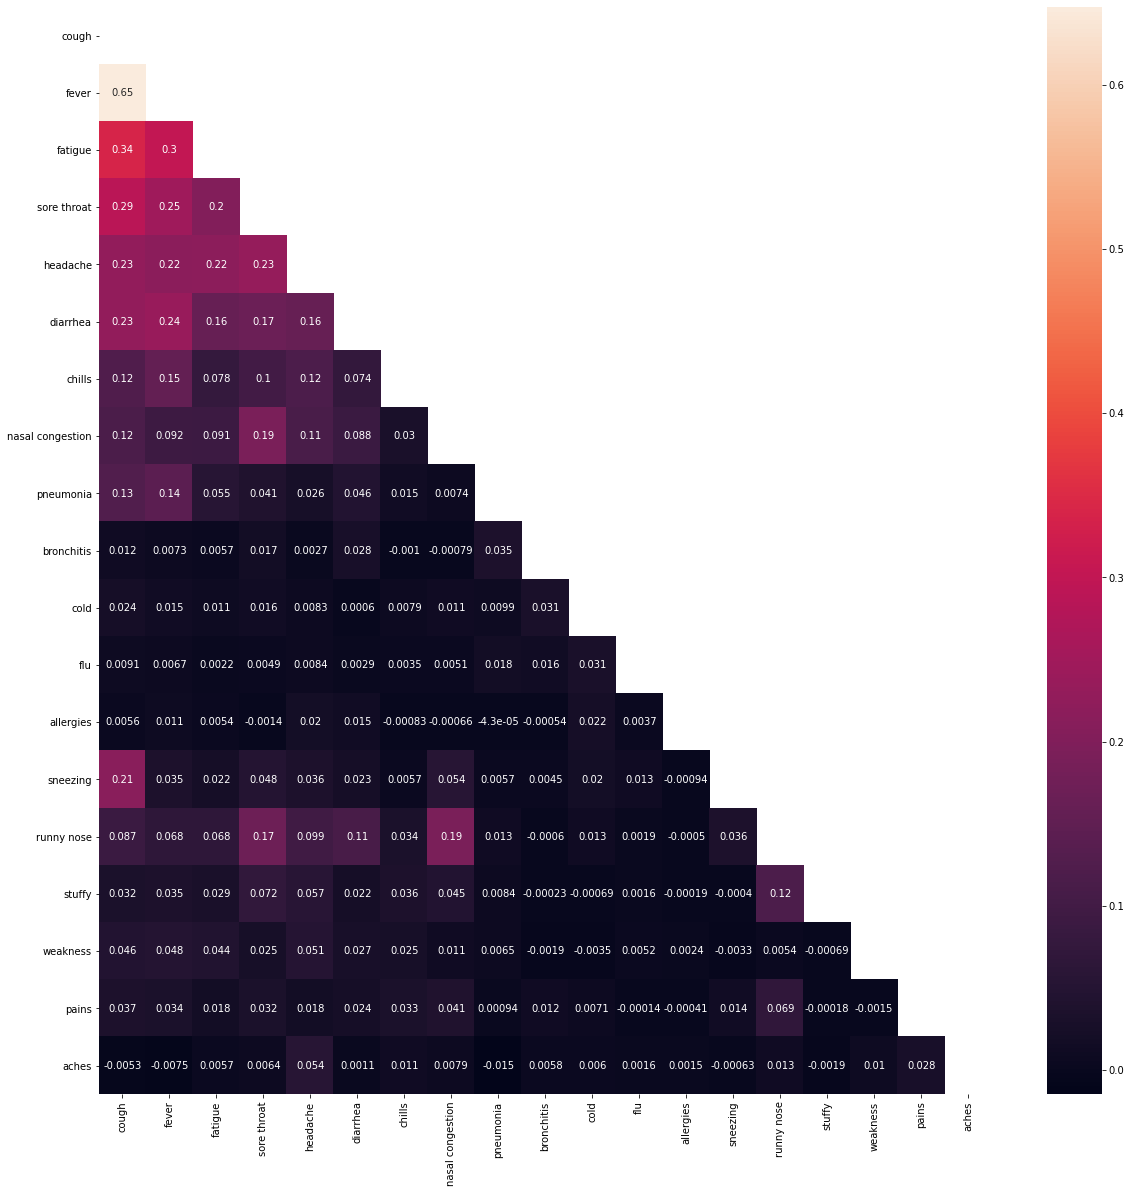

In [42]:
# plot the heatmap based the correlation dataframe
mask = np.zeros_like(symptoms_df.corr()*-1)
mask[np.triu_indices_from(mask)] = True

fig,ax = plt.subplots(figsize=(20,20))
sns.heatmap(symptoms_df.corr(), mask=mask, annot=True)

##### Symtoms analyzation by apriori algorithm

In [43]:

import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [44]:
# any positive values are converted to a 1 and anything less the 0 is set to 0
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

symptoms_sets_df = symptoms_df.applymap(encode_units)

In [69]:
frequent_itemsets = apriori(symptoms_sets_df, min_support=0.005, use_colnames=True)
frequent_itemsets.head(10)

,support,itemsets
0,0.035618,(cough)
1,0.046452,(fever)
2,0.013283,(fatigue)
3,0.009388,(headache)
4,0.008164,(diarrhea)
5,0.070938,(pneumonia)
6,0.005715,(cold)
7,0.102128,(flu)
8,0.005665,(weakness)
9,0.041803,(aches)


In [68]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules = rules.sort_values(by=['confidence'], ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,"(cough, fatigue)",(fever),0.007637,0.046452,0.006864,0.898671,19.346034,0.006509,9.410420
4,"(fever, fatigue)",(cough),0.007923,0.035618,0.006864,0.866293,24.321775,0.006581,7.212653
8,"(cough, pneumonia)",(fever),0.008545,0.046452,0.007250,0.848552,18.267108,0.006854,6.296218
1,(cough),(fever),0.035618,0.046452,0.026902,0.755298,16.259593,0.025248,3.896775
7,"(fever, pneumonia)",(cough),0.010917,0.035618,0.007250,0.664149,18.646435,0.006862,2.871456
3,(fatigue),(fever),0.013283,0.046452,0.007923,0.596466,12.840352,0.007306,2.362992
0,(fever),(cough),0.046452,0.035618,0.026902,0.579134,16.259593,0.025248,2.291424
2,(fatigue),(cough),0.013283,0.035618,0.007637,0.574976,16.142851,0.007164,2.269007
6,(fatigue),"(fever, cough)",0.013283,0.026902,0.006864,0.516714,19.207132,0.006506,2.013505


##### Hierarchical Clustering

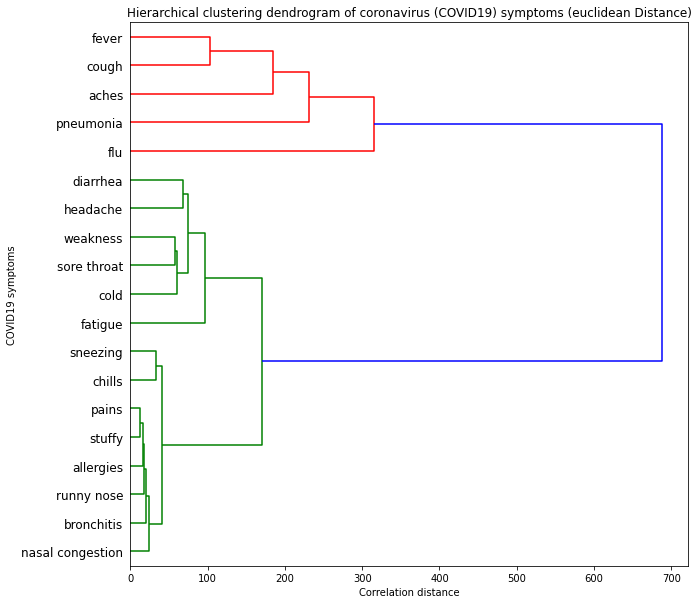

In [71]:
# Symptoms classification with hierarchical Clustering in distance dataframe
import scipy.cluster.hierarchy as sch
fig = plt.figure(figsize=(10,10))
dendrogram = sch.dendrogram(sch.linkage(distance_df, method='ward'), labels=list(distance_df.columns), orientation='right')
plt.title('Hierarchical clustering dendrogram of coronavirus (COVID19) symptoms (euclidean Distance)')
plt.xlabel('Correlation distance')
plt.ylabel('COVID19 symptoms')
plt.show()

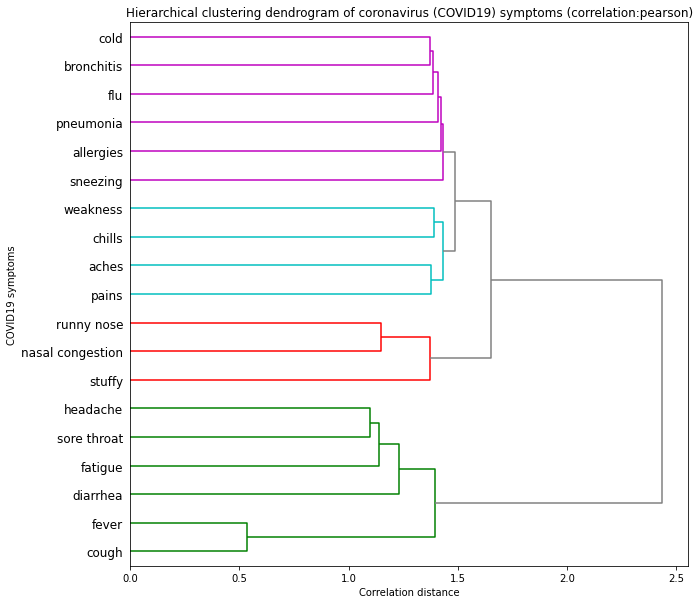

In [70]:
# Symptoms classification with hierarchical Clustering in correlation dataframe
import scipy.cluster.hierarchy as sch
fig = plt.figure(figsize=(10,10))
dendrogram = sch.dendrogram(sch.linkage(symptoms_correlation, method='ward'), labels=list(symptoms_correlation.columns), orientation='right',color_threshold=1.45, above_threshold_color='grey')
plt.title('Hierarchical clustering dendrogram of coronavirus (COVID19) symptoms (correlation:pearson)')
plt.xlabel('Correlation distance')
plt.ylabel('COVID19 symptoms')
plt.show()

##### Results

I analyzed the assosiation rule and correlation with all coronavirus symptoms in three methods:


Based on the hierachical clustering dendrogram of euclidean distance dataframe, all symptoms can be classified to three classes:

--fever; cough; aches; pneumonia; flu

--diarrhea; headache; weakness; sore throat; cold; fatigue

--sneezing; chills; pains; stuffy; allergies; runny nose; bronchitis; nasal congestion

Based on the hierachical clustering dendrogram of correlation dataframe, all symptoms can be classified to four classes:

--cold; bronchitis; flu; pneumonia; allergies; sneezing

--weakness; chills; aches; pains

--runny nose; nasal congestion; stuffy

--headache; sore throat; fatigue; diarrhea; fever; cough

Based on the results of assosiation rule by apriori algorithm:
the sorted confidence column showed the strong relationship between cough and fever.

#### Association of coronavirus risk factors

Build model to answer the questions: Determine the association of coronavirus risk factors

In [49]:
# count the risk factor words from text column and report the words count dataframe
column_risk1 = covid19_paper['text'].str.contains(risk_factors[0]).astype('uint')
risk_factors_df = pd.DataFrame(data=[column_risk1]).T

for i in range(len(risk_factors)-1):
    colum_risk_factors = covid19_paper['text'].str.contains(risk_factors[i+1]).astype('uint')
    colum_risk_factors_df = pd.DataFrame(data=[colum_risk_factors]).T
    risk_factors_df = pd.concat([risk_factors_df,colum_risk_factors_df], axis=1)
risk_factors_df.columns = risk_factors
risk_factors_df.head()

,male,female,age,asthma,copd,lung cancer,cystic fibrosis,pulmonary fibrosis,heart disease,cardiomyopathy,heart failure,hypertension,diabetes,obesity,cancer,hiv,aids,smoking,alcohol
8141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10752,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10889,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10971,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11617,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
# report the count value of all risk factors
count_risk_factors_df = risk_factors_df.sum()
count_risk_factors_df

male                  13235
female                 7218
age                   83218
asthma                  948
copd                    585
lung cancer             417
cystic fibrosis         120
pulmonary fibrosis      268
heart disease           874
cardiomyopathy          274
heart failure          1153
hypertension           4267
diabetes               5491
obesity                2391
cancer                 5156
hiv                    1957
aids                    634
smoking                1351
alcohol                1274
dtype: int64

In [73]:
# Based on the words count dataframe report the assosication dataframe with all risk factors using euclidean distance
risk_factors_T = risk_factors_df.T
distance_array = squareform(pdist(risk_factors_T))
distance_risk_factors_df = pd.DataFrame(distance_array, columns=risk_factors_T.index, index=risk_factors_T.index)
distance_risk_factors_df

,male,female,age,asthma,copd,lung cancer,cystic fibrosis,pulmonary fibrosis,heart disease,cardiomyopathy,heart failure,hypertension,diabetes,obesity,cancer,hiv,aids,smoking,alcohol
male,0.000000,77.569324,274.978181,117.528720,116.146459,116.370099,115.503247,115.866302,116.888836,115.779964,117.652029,121.457812,125.610509,120.199834,131.099199,121.507201,117.179350,117.200683,118.401858
female,77.569324,0.000000,281.524422,89.286057,87.675538,87.206651,85.638776,86.278618,88.825672,86.290208,90.448881,102.698588,108.143423,95.723560,108.719823,94.609725,88.158947,90.592494,90.410176
age,274.978181,281.524422,0.000000,287.864551,288.036456,288.230810,288.475302,288.312331,287.749891,288.374756,287.678640,284.518892,283.980633,286.637402,285.674640,288.151002,288.242953,287.337780,287.996528
asthma,117.528720,89.286057,287.864551,0.000000,34.713110,36.152455,32.280025,34.727511,41.641326,34.813790,45.155288,69.159237,76.804948,55.308227,76.720271,53.432200,39.420807,46.679760,46.861498
copd,116.146459,87.675538,288.036456,34.713110,0.000000,30.594117,26.286879,28.792360,36.918830,29.206164,40.644803,66.678332,75.086617,53.441557,74.612331,49.979996,34.684290,41.976184,43.023250
lung cancer,116.370099,87.206651,288.230810,36.152455,30.594117,0.000000,23.086793,25.942244,35.791060,26.286879,39.572718,68.220232,76.602872,52.915026,68.840395,48.662100,32.419130,41.158231,41.024383
cystic fibrosis,115.503247,85.638776,288.475302,32.280025,26.286879,23.086793,0.000000,19.595918,31.464265,19.849433,35.679126,66.219333,74.799733,50.089919,72.512068,45.530210,27.459060,38.327536,37.336309
pulmonary fibrosis,115.866302,86.278618,288.312331,34.727511,28.792360,25.942244,19.595918,0.000000,33.793490,23.194827,37.589892,66.970143,75.663730,51.487863,73.498299,47.148701,30.033315,40.137264,39.242834
heart disease,116.888836,88.825672,287.749891,41.641326,36.918830,35.791060,31.464265,33.793490,0.000000,33.196385,42.626283,66.098411,74.370693,55.272054,76.511437,52.848841,38.574603,46.551047,46.173586
cardiomyopathy,115.779964,86.290208,288.374756,34.813790,29.206164,26.286879,19.849433,23.194827,33.196385,0.000000,36.013886,66.820655,75.478474,51.371198,73.525506,47.169906,30.066593,40.311289,39.344631


In [52]:
risk_factors_correlation = risk_factors_df.corr(method ='pearson')
risk_factors_correlation

,male,female,age,asthma,copd,lung cancer,cystic fibrosis,pulmonary fibrosis,heart disease,cardiomyopathy,heart failure,hypertension,diabetes,obesity,cancer,hiv,aids,smoking,alcohol
male,1.000000,0.723573,0.157319,0.031187,0.043596,0.008903,-0.002550,0.009162,0.046093,0.015923,0.047301,0.143317,0.126376,0.072667,0.021750,0.010267,0.005701,0.077319,0.035267
female,0.723573,1.000000,0.108191,0.021038,0.015580,-0.002418,-0.003845,0.006431,0.024925,0.007617,0.015033,0.051172,0.042304,0.028190,0.006983,0.006138,0.005261,0.039226,0.034122
age,0.157319,0.108191,1.000000,0.024582,0.023027,0.014564,-0.001542,0.012192,0.031595,0.006516,0.029430,0.079438,0.078546,0.048015,0.047166,0.004468,0.009902,0.039953,0.014544
asthma,0.031187,0.021038,0.024582,1.000000,0.216552,0.042319,0.036528,0.006748,0.042812,0.006603,0.023174,0.096235,0.106045,0.084333,0.035978,0.009805,0.013207,0.046175,0.004892
copd,0.043596,0.015580,0.023027,0.216552,1.000000,0.063884,0.024795,0.027870,0.062884,0.004967,0.047409,0.120324,0.113014,0.043643,0.039806,0.013886,0.009309,0.092793,-0.000848
lung cancer,0.008903,-0.002418,0.014564,0.042319,0.063884,1.000000,0.007535,0.015862,0.004471,-0.002149,-0.001522,0.002826,0.003688,-0.002349,0.280070,-0.002428,-0.003273,0.044786,0.000869
cystic fibrosis,-0.002550,-0.003845,-0.001542,0.036528,0.024795,0.007535,1.000000,0.010027,0.004134,-0.001152,-0.002369,-0.003186,0.004792,-0.001543,0.006563,0.001060,-0.001754,-0.000071,-0.002491
pulmonary fibrosis,0.009162,0.006431,0.012192,0.006748,0.027870,0.015862,0.010027,1.000000,-0.003081,0.005671,0.003686,0.016838,0.006437,-0.000082,0.001935,-0.003236,-0.002622,0.002845,-0.002005
heart disease,0.046093,0.024925,0.031595,0.042812,0.062884,0.004471,0.004134,-0.003081,1.000000,0.044056,0.098865,0.190752,0.180110,0.064130,0.028537,0.006288,0.008754,0.019936,0.000894
cardiomyopathy,0.015923,0.007617,0.006516,0.006603,0.004967,-0.002149,-0.001152,0.005671,0.044056,1.000000,0.112589,0.028700,0.020313,0.011020,0.002601,-0.000552,0.002161,-0.003879,-0.003766


##### Hierarchical Clustering

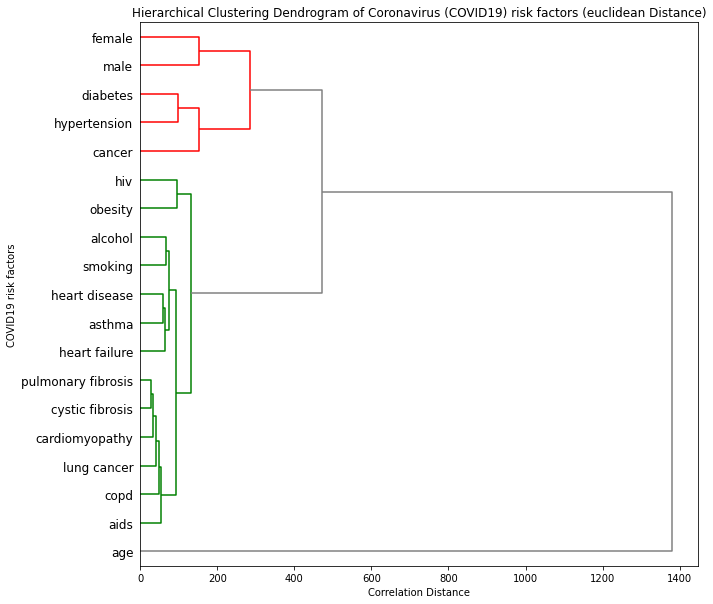

In [53]:
# Risk factors classification with hierarchical clustering in distance dataframe

import scipy.cluster.hierarchy as sch
fig = plt.figure(figsize=(10,10))
dendrogram = sch.dendrogram(sch.linkage(distance_risk_factors_df, method='ward'), labels=list(distance_risk_factors_df.columns), orientation='right',color_threshold=300, above_threshold_color='grey')
plt.title('Hierarchical Clustering Dendrogram of Coronavirus (COVID19) risk factors (euclidean Distance)')
plt.xlabel('Correlation Distance')
plt.ylabel('COVID19 risk factors')
plt.show()

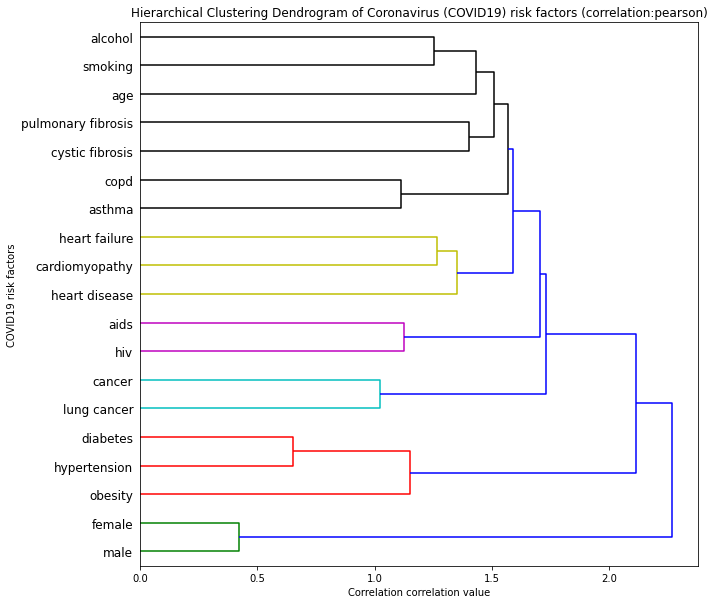

In [54]:
# Risk factors classification with hierarchical clustering in correlation dataframe
fig = plt.figure(figsize=(10,10))
dendrogram = sch.dendrogram(sch.linkage(risk_factors_correlation, method='ward'), labels=list(risk_factors_correlation.columns), orientation='right')
plt.title('Hierarchical Clustering Dendrogram of Coronavirus (COVID19) risk factors (correlation:pearson)')
plt.xlabel('Correlation correlation value')
plt.ylabel('COVID19 risk factors')
plt.show()

##### Results

I analyzed the assosiation rule and correlation with all coronavirus symptoms in two methods:

Based on the hierachical clustering dendrogram of euclidean distance dataframe, all risk factors can be classified to two classes:

--female; male; diabetes; hypertension; cancer

--age;	asthma;	copd;	lung cancer;	cystic fibrosis;	pulmonary fibrosis;	heart disease;	cardiomyopathy;	heart failure;	obesity;	hiv;	aids;	smoking;	alcohol

Based on the hierachical clustering dendrogram of correlation dataframe, all risk factors can be classified to six classes:

--female; male

--diabetes; hypertension; obesity

--cancer; lung cancer

--aids; hiv

--heart failure; cardiomyopathy;	heart disease

--age; asthma; copd; cystic fibrosis; pulmonary fibrosis;	smoking; alcohol

### Deriving insights about policy and guidance to tackle the outbreak based on model findings

Through my NLP model analyzation and text mining over 400,000 unique biomedical research papers. I answered two technical questions: 

--Determine the association of coronavirus symptoms

--Determine the association of coronavirus risk factors



Based on the results and answers of two questions. There are several insights and suggests for scientists, doctors, nurses, healthcare professionals, industry, and governments.





#### Governments:

--Governments should increase awareness and understanding of the diease 

Because of the coronavirus analyzation result, covid19 is similer to sars and other coronaviru, but there symptoms importance are different.

--Targeted outreach to at-risk populations

Because of the COVID19 risk factors analyzation results, different people have different risk level. For example,older adults, male, and people with other diseases.

--Quarantine and keep social distance

Based on the characteristics of previous coronavirus and the relationship between covid19 and other coronavirus. The virus is contagious, people should keep social distance and avoid crowds.


#### Hospital:

--Quick screening and evaluation of patients

Based on the symptoms analyzation between covid19 and other coronavirus. People who has fever, cough, and fatigue has high probability of COVID19 during the pandemic.

--Risk prevention

Based on the risk factors frequency distribution, people with diabetes, cancer, hypertension, obesity, and hiv will get higher risk to get covid19. Therefore, hospital should take more care about these people.

#### Scientists:

--Author and paper classification

Based on the authors count list and paper classification with different coronavirus types. The scientists can find the previous research paper with specific coronavirus type, also can select the paper with authors who published several covid19 papers.

